# COMPAS: sex race age_cat

## Load Dataset and Data Analysis

In [33]:
import numpy as np
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt

# Load in the 2 year COMPAS Recidivism dataset
df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

In [34]:
df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

In [35]:
# Detect sensitive attributes
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)
print(sensitive_attributes.keys())

{'sex': 'Gender', 'dob': 'Age', 'age': 'Age', 'race': 'Ethnicity'}
dict_keys(['sex', 'dob', 'age', 'race'])


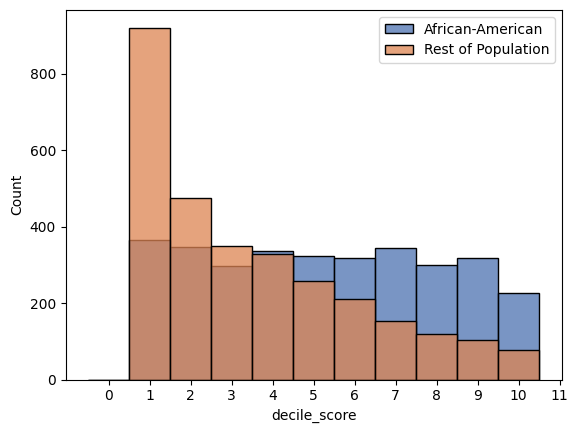

In [36]:
group1 = {"race": ["African-American"]}
group2 = df["race"] != "African-American"

plt.rcParams['font.family'] = 'sans-serif'
fl.plot.distr_plot(df, "decile_score", [group1, group2])
plt.legend(["African-American", "Rest of Population"])
plt.show()

## Prepare and Create the Task

In [37]:
from sklearn.model_selection import train_test_split

# Select the features to use
df = df[["sex", "race", "age_cat", "c_charge_degree", "priors_count", "score_text", "two_year_recid"]]
df.rename(columns={"score_text": "risk"}, inplace=True)

#! convert two_year_recid into categorical
df["two_year_recid"] = df["two_year_recid"].apply(lambda x: "Reoffended" if x == 1 else "Did Not Reoffend")
#!

#! race: African-American and Non-African-American
df['race'] = df['race'].apply(lambda x: 'African-American' if x == 'African-American' else 'Not African-American')
#!

df

,sex,race,age_cat,c_charge_degree,priors_count,risk,two_year_recid
0,Male,Not African-American,Greater than 45,F,0,Low,Did Not Reoffend
1,Male,African-American,25 - 45,F,0,Low,Reoffended
2,Male,African-American,Less than 25,F,4,Low,Reoffended
3,Male,Not African-American,25 - 45,M,0,Low,Did Not Reoffend
4,Male,Not African-American,25 - 45,F,14,Medium,Reoffended
...,...,...,...,...,...,...,...
6167,Male,African-American,Less than 25,F,0,Medium,Did Not Reoffend
6168,Male,African-American,Less than 25,F,0,Low,Did Not Reoffend
6169,Male,Not African-American,Greater than 45,F,0,Low,Did Not Reoffend
6170,Female,African-American,25 - 45,M,3,Low,Did Not Reoffend


In [38]:
names_of_categorical_columns = ["sex", "race", "age_cat", "c_charge_degree", "risk"]

# Splitting data into features (X) and target (y)
X = df.drop(columns=['two_year_recid'])
y = df['two_year_recid']

# Split the data into train and validation sets (80:20)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from Tablet import create

header_description = "Predict whether an individual will recidivate within two years based on demographic and criminal history."
nl_instruction = "Given features like gender, race, age category, charge degree, prior count, and crime risk level, predict whether an individual will recidivate within two years."

create.create_task(train_x,
                   val_x,
                   train_y,
                   val_y,
                   name="COMPAS",
                   header=header_description,
                   nl_instruction=nl_instruction,
                   categorical_columns=names_of_categorical_columns,
                   num=0,
                   num_gpt3_revisions=10,
                   openai_key_path="./openai_key.txt",
                   save_loc="../data/benchmark"
                   )

# German Credit: Age Sex

In [ ]:
import numpy as np
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt

df = pd.read_csv("../data/german_credit_data.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.dropna()
df

In [31]:
# Recover the "job" column from numeric to categorical
job_mapping = {
    0: "unskilled and non-resident",
    1: "unskilled and resident",
    2: "skilled",
    3: "highly skilled"
}

df['Job'] = df['Job'].map(job_mapping)

# Convert the "age" attribute from numeric to categorical
bins = [0, 24, 45, float('inf')]
labels = ["Less than 25", "25 - 45", "Greater than 45"]

df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True, include_lowest=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,Less than 25,female,skilled,own,little,moderate,5951,48,radio/TV,bad
3,25 - 45,male,skilled,free,little,little,7882,42,furniture/equipment,good
4,Greater than 45,male,skilled,free,little,little,4870,24,car,bad
7,25 - 45,male,highly skilled,rent,little,moderate,6948,36,car,good
9,25 - 45,male,highly skilled,own,little,moderate,5234,30,car,bad


In [32]:
from sklearn.model_selection import train_test_split

# Splitting data into features (X) and target (y)
X = df.drop(columns=['Risk'])
y = df['Risk']

# Split the data into train and validation sets (80:20)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_x.shape, val_x.shape, train_y.shape, val_y.shape

((417, 9), (105, 9), (417,), (105,))

In [33]:
# Detect sensitive attributes
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)
print(sensitive_attributes.keys())

{'Age': 'Age', 'Sex': 'Gender'}
dict_keys(['Age', 'Sex'])


In [34]:
names_of_categorical_columns = ['Age',
                                'Sex',
                                'Job',
                                'Housing',
                                'Saving accounts',
                                'Checking account',
                                'Purpose']

header_description ="Predict the credit risk of a German bank customer based on their profile data."
nl_instruction = "Given the features of a bank customer, such as age, job type, and housing situation, predict whether the customer is a good or bad credit risk."

In [ ]:
from Tablet import create

create.create_task(train_x,
                   val_x,
                   train_y,
                   val_y,
                   name="GermanCredit",
                   header=header_description,
                   nl_instruction=nl_instruction,
                   categorical_columns=names_of_categorical_columns,
                   num=0,
                   num_gpt3_revisions=10,
                   openai_key_path="./openai_key.txt",
                   save_loc="../data/benchmark"
                   )